In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

import numpy as np
import pandas as pd
import random
import os
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score
import sys
from types import SimpleNamespace
import json

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset


Distribusi kelas:
label
psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
xanthomas                       53
pustular psoriasis              53
pilomatricoma                   53
Name: count, Length: 114, dtype: int64


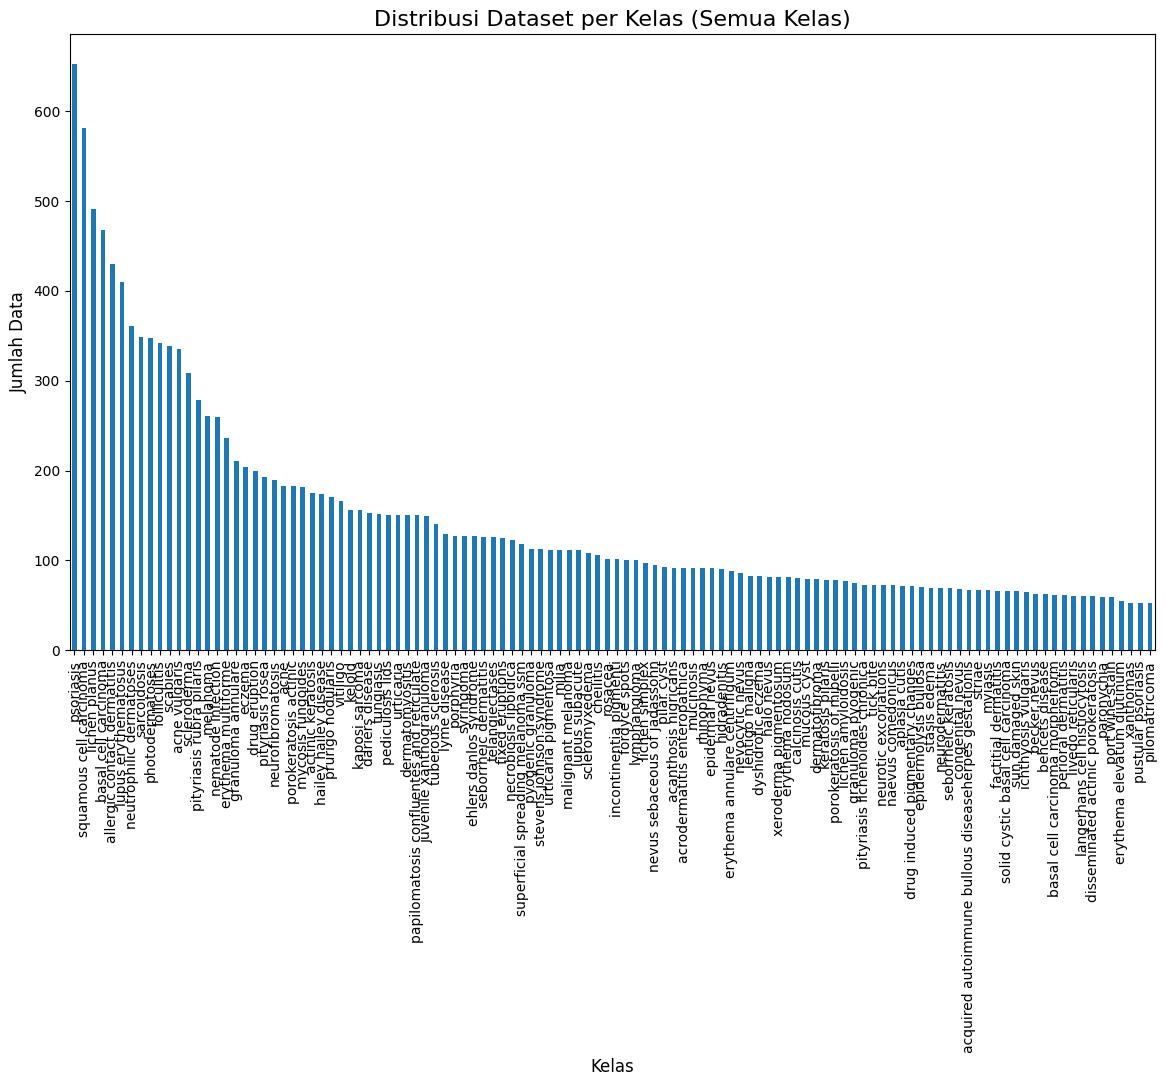

In [3]:
class Fitzpatrick17kDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None, img_ext=".jpg"):
        """
        Args:
            csv_file (str): Path to the CSV file (fitzpatrick17k.csv)
            img_dir (str): Path to the folder containing images
            transform (callable, optional): Transform to apply to the images
            target_transform (callable, optional): Transform to apply to labels
            img_ext (str): Image file extension, e.g., '.jpg' or '.png'
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_ext = img_ext
        self.classes = sorted(self.data['label'].unique())

        self.num_classes = len(self.classes)

        # Create a mapping from label string to integer
        self.label2idx = {label: idx for idx, label in enumerate(self.classes)}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}

        # Precompute image paths and labels with tqdm
        self.samples = []
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Loading dataset"):
            img_name = f"{row['md5hash']}{self.img_ext}"
            img_path = os.path.join(self.img_dir, img_name)
            label = self.label2idx[row['label']]
            self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
        
img_dir = '/kaggle/input/fitzpatrick/dataset/data/finalfitz17k'

csv_path = "/kaggle/input/fitzpatrick/fitzpatrick17k.csv"

# Membaca file CSV
df = pd.read_csv(csv_path)

# Visualisasi distribusi kelas
if "label" in df.columns:
    label_counts = df['label'].value_counts()

    print("\nDistribusi kelas:")
    print(label_counts)

    plt.figure(figsize=(14, 8))
    label_counts.plot(kind='bar')
    plt.title("Distribusi Dataset per Kelas (Semua Kelas)", fontsize=16)
    plt.xlabel("Kelas", fontsize=12)
    plt.ylabel("Jumlah Data", fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
else:
    print("Kolom 'label' tidak ditemukan dalam dataset.")


# VAN Util

In [4]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class LKA(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv0 = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)
        self.conv_spatial = nn.Conv2d(dim, dim, 7, stride=1, padding=9, groups=dim, dilation=3)
        self.conv1 = nn.Conv2d(dim, dim, 1)


    def forward(self, x):
        u = x.clone()        
        attn = self.conv0(x)
        attn = self.conv_spatial(attn)
        attn = self.conv1(attn)

        return u * attn

class LSKA(nn.Module):
    def __init__(self, dim, k_size):
        super().__init__()

        self.k_size = k_size

        if k_size == 7:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 3), stride=(1,1), padding=(0,(3-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(3, 1), stride=(1,1), padding=((3-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 3), stride=(1,1), padding=(0,2), groups=dim, dilation=2)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(3, 1), stride=(1,1), padding=(2,0), groups=dim, dilation=2)
        elif k_size == 11:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 3), stride=(1,1), padding=(0,(3-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(3, 1), stride=(1,1), padding=((3-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 5), stride=(1,1), padding=(0,4), groups=dim, dilation=2)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(5, 1), stride=(1,1), padding=(4,0), groups=dim, dilation=2)
        elif k_size == 23:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 5), stride=(1,1), padding=(0,(5-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(5, 1), stride=(1,1), padding=((5-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 7), stride=(1,1), padding=(0,9), groups=dim, dilation=3)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(7, 1), stride=(1,1), padding=(9,0), groups=dim, dilation=3)
        elif k_size == 35:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 5), stride=(1,1), padding=(0,(5-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(5, 1), stride=(1,1), padding=((5-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 11), stride=(1,1), padding=(0,15), groups=dim, dilation=3)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(11, 1), stride=(1,1), padding=(15,0), groups=dim, dilation=3)
        elif k_size == 41:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 5), stride=(1,1), padding=(0,(5-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(5, 1), stride=(1,1), padding=((5-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 13), stride=(1,1), padding=(0,18), groups=dim, dilation=3)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(13, 1), stride=(1,1), padding=(18,0), groups=dim, dilation=3)
        elif k_size == 53:
            self.conv0h = nn.Conv2d(dim, dim, kernel_size=(1, 5), stride=(1,1), padding=(0,(5-1)//2), groups=dim)
            self.conv0v = nn.Conv2d(dim, dim, kernel_size=(5, 1), stride=(1,1), padding=((5-1)//2,0), groups=dim)
            self.conv_spatial_h = nn.Conv2d(dim, dim, kernel_size=(1, 17), stride=(1,1), padding=(0,24), groups=dim, dilation=3)
            self.conv_spatial_v = nn.Conv2d(dim, dim, kernel_size=(17, 1), stride=(1,1), padding=(24,0), groups=dim, dilation=3)

        self.conv1 = nn.Conv2d(dim, dim, 1)


    def forward(self, x):
        u = x.clone()
        attn = self.conv0h(x)
        attn = self.conv0v(attn)
        attn = self.conv_spatial_h(attn)
        attn = self.conv_spatial_v(attn)
        attn = self.conv1(attn)
        return u * attn

class Attention(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)
        self.activation = nn.GELU()
        self.spatial_gating_unit = LKA(d_model)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)

    def forward(self, x):
        shorcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        x = x + shorcut
        return x

class AttentionLSKA(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)
        self.activation = nn.GELU()
        self.spatial_gating_unit = LSKA(d_model)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)

    def forward(self, x):
        shorcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        x = x + shorcut
        return x

class Block(nn.Module):
    def __init__(self, dim, mlp_ratio=4., drop=0.,drop_path=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)
        self.attn = Attention(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        layer_scale_init_value = 1e-2            
        self.layer_scale_1 = nn.Parameter(
            layer_scale_init_value * torch.ones((dim)), requires_grad=True)
        self.layer_scale_2 = nn.Parameter(
            layer_scale_init_value * torch.ones((dim)), requires_grad=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = x + self.drop_path(self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        return x

class BlockLSKA(nn.Module):
    def __init__(self, dim, mlp_ratio=4., drop=0.,drop_path=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)
        self.attn = Attention(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        layer_scale_init_value = 1e-2            
        self.layer_scale_1 = nn.Parameter(
            layer_scale_init_value * torch.ones((dim)), requires_grad=True)
        self.layer_scale_2 = nn.Parameter(
            layer_scale_init_value * torch.ones((dim)), requires_grad=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = x + self.drop_path(self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.BatchNorm2d(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = self.norm(x)        
        return x, H, W

class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x):
        x = self.dwconv(x)
        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict

# model

In [5]:
model_urls = {
    "van_b0": "https://huggingface.co/Visual-Attention-Network/VAN-Tiny-original/resolve/main/van_tiny_754.pth.tar",
    "van_b1": "https://huggingface.co/Visual-Attention-Network/VAN-Small-original/resolve/main/van_small_811.pth.tar",
    "van_b2": "https://huggingface.co/Visual-Attention-Network/VAN-Base-original/resolve/main/van_base_828.pth.tar",
    "van_b3": "https://huggingface.co/Visual-Attention-Network/VAN-Large-original/resolve/main/van_large_839.pth.tar",
}

def load_model_weights(model, arch, num_classes):
    url = model_urls[arch]
    checkpoint = torch.hub.load_state_dict_from_url(
        url=url, map_location="cpu", check_hash=True
    )
    strict = True
    if num_classes != 1000:
        strict = False
        del checkpoint["state_dict"]["head.weight"]
        del checkpoint["state_dict"]["head.bias"]
    model.load_state_dict(checkpoint["state_dict"], strict=strict)
    return model

In [6]:
class VAN(nn.Module):
    def __init__(
        self,
        img_size=224,
        in_chans=3,
        num_classes=1000,
        embed_dims=[64, 128, 256, 512],
        mlp_ratios=[4, 4, 4, 4],
        drop_rate=0.,
        drop_path_rate=0.,
        norm_layer=nn.LayerNorm,
        depths=[3, 4, 6, 3],
        num_stages=4,
        attn_type='LKA',
        flag=False
    ):
        super().__init__()

        if not flag:
            self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages
        self.attn_type = attn_type

        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        for i in range(num_stages):
            patch_embed = OverlapPatchEmbed(
                img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                patch_size=7 if i == 0 else 3,
                stride=4 if i == 0 else 2,
                in_chans=in_chans if i == 0 else embed_dims[i - 1],
                embed_dim=embed_dims[i]
            )

            if attn_type == 'LKA':
                block = nn.ModuleList([
                    Block(dim=embed_dims[i],
                          mlp_ratio=mlp_ratios[i],
                          drop=drop_rate,
                          drop_path=dpr[cur + j])
                    for j in range(depths[i])
                ])
            elif attn_type == 'LSKA':
                block = nn.ModuleList([
                    BlockLSKA(dim=embed_dims[i],
                          mlp_ratio=mlp_ratios[i],
                          drop=drop_rate,
                          drop_path=dpr[cur + j])
                    for j in range(depths[i])
                ])

            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"block{i + 1}", block)
            setattr(self, f"norm{i + 1}", norm)

        # Classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def freeze_patch_emb(self):
        for param in self.patch_embed1.parameters():
            param.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        # Positional embeddings that should not apply weight decay
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            block = getattr(self, f"block{i + 1}")
            norm = getattr(self, f"norm{i + 1}")

            x, H, W = patch_embed(x)
            for blk in block:
                x = blk(x)
            x = x.flatten(2).transpose(1, 2)
            x = norm(x)

            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [7]:
def get_model(args):
    """
    Returns model instance according to args.model_name
    """
    num_classes = getattr(args, "num_classes", 1000)

    if args.model_name == 'resnet18':
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)

        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features, num_classes)
        )

    elif args.model_name == 'van':
        embed_dims = [32, 64, 160, 256]
        depths = [3, 3, 5, 2]
        if args.van_arch == 'van_b1':
            embed_dims = [64, 128, 320, 512]
            depths = [2, 2, 4, 2]    
        elif args.van_arch == 'van_b2':
            embed_dims = [64, 128, 320, 512]
            depths = [3, 3, 12, 3]

        elif args.van_arch == 'van_b3':
            embed_dims = [64, 128, 320, 512]
            depths = [3, 5, 27, 3]            
        model = VAN(
            embed_dims=embed_dims, mlp_ratios=[8, 8, 4, 4],
            norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=depths,
            num_classes=args.num_classes)
        model.default_cfg = _cfg()
        model = load_model_weights(model, args.van_arch, args.num_classes)
        return model

    else:
        raise ValueError(f"Unknown model name: {args.model_name}")

    return model

In [8]:
SEED = 32
FOLD = 5
BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
set_seed(SEED)



# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.617, 0.477, 0.423),
                         (0.232, 0.204, 0.207)),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.617, 0.477, 0.423),
                         (0.232, 0.204, 0.207)),
])

# --- Dataset ---
fold = str(FOLD)
train_csv_path = f"/kaggle/input/fitzpatrick/train_fold{fold}.csv"
test_csv_path = f"/kaggle/input/fitzpatrick/test_fold{fold}.csv"

train_dataset = Fitzpatrick17kDataset(
    csv_file=train_csv_path,
    img_dir=img_dir,
    transform=train_transform,
    img_ext=".jpg"
)

test_dataset = Fitzpatrick17kDataset(
    csv_file=test_csv_path,
    img_dir=img_dir,
    transform=test_transform,
    img_ext=".jpg"
)

num_classes = train_dataset.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE,
                         shuffle=False, num_workers=2)



args = SimpleNamespace(
    exp_name='exp',
    num_classes=num_classes,
    model_name='van',
    van_arch='van_b3',
    attn_type='LKA',
    epochs=50,
    lr=0.0001,
    momentum=0.9,
    no_cuda=False,
    eval=False,
    seed=42,
    fold=FOLD,
    simclr_ckpt=None,
    freeze_backbone=False
)

Loading dataset: 100%|██████████| 3315/3315 [00:00<00:00, 23701.40it/s]


In [9]:
model = get_model(args)
model = model.to(device)

# freeze all
for p in model.parameters():
    p.requires_grad = False

# unfreeze last stage blocks and norm and patch_embed, plus head
for name, module in model.named_children():
    # contoh unfreeze block4, norm4, patch_embed4
    pass

# praktisnya:
for p in model.patch_embed4.parameters():
    p.requires_grad = True
for p in model.block4.parameters():
    p.requires_grad = True
for p in model.norm4.parameters():
    p.requires_grad = True
for p in model.head.parameters():
    p.requires_grad = True


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad],lr=args.lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

NUM_FOLDS = 5
NUM_EPOCHS = args.epochs
SEED = SEED  # gunakan seed yang sudah ada di workspace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure checkpoint dirs
def _init_(args):
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    if not os.path.exists('checkpoints/' + args.exp_name):
        os.makedirs('checkpoints/' + args.exp_name)
    if not os.path.exists('checkpoints/' + args.exp_name + '/' + 'models'):
        os.makedirs('checkpoints/' + args.exp_name + '/' + 'models')
_init_(args)

epoch_hist = {
    "train_loss": [], "test_loss": [],
    "train_acc": [],  "test_acc": [],
    "train_f1": [],   "test_f1_macro": []
    }
all_results = []

Downloading: "https://huggingface.co/Visual-Attention-Network/VAN-Large-original/resolve/main/van_large_839.pth.tar" to /root/.cache/torch/hub/checkpoints/van_large_839.pth.tar
100%|██████████| 513M/513M [00:01<00:00, 340MB/s]


Total parameters: 44.31M
Trainable parameters: 10.39M


In [10]:
START_FOLD = 1
END_FOLD = 5

for fold in range(START_FOLD, END_FOLD + 1):
    print("\n" + "="*60)
    print(f"Starting fold {fold}/{END_FOLD}")
    print("="*60)

    # update args & csv paths per fold
    args.fold = fold
    train_csv_path = f"/kaggle/input/fitzpatrick/train_fold{fold}.csv"
    test_csv_path  = f"/kaggle/input/fitzpatrick/test_fold{fold}.csv"

    # create datasets/loaders
    train_dataset = Fitzpatrick17kDataset(csv_file=train_csv_path, img_dir=img_dir,
                                         transform=train_transform, img_ext=".jpg")
    test_dataset  = Fitzpatrick17kDataset(csv_file=test_csv_path, img_dir=img_dir,
                                         transform=test_transform, img_ext=".jpg")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2)

    # update classes if needed
    args.num_classes = train_dataset.num_classes

    # reset seed per fold (keputusan: SEED + fold)
    set_seed(SEED + fold)

    # build model/optimizer/scheduler per fold (fresh start)
    best_acc = 0.0
    best_f1_macro = 0.0
    fold_start = time.time()
    # training per epoch

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_preds, all_train_labels = [], []

        for imgs, labels in tqdm(train_loader, desc=f"Fold{fold} Train E{epoch+1}/{NUM_EPOCHS}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        scheduler.step()

        # train metrics
        train_acc = 100.0 * correct_train / total_train if total_train else 0.0
        train_loss = running_train_loss / total_train if total_train else 0.0
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

        # eval on test_loader
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_test_preds, all_test_labels = [], []

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc=f"Fold{fold} Eval E{epoch+1}/{NUM_EPOCHS}"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_test_loss += loss.item() * imgs.size(0)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        test_acc = 100.0 * correct_test / total_test if total_test else 0.0
        test_loss = running_test_loss / total_test if total_test else 0.0
        test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
        test_recall = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
        test_f1_macro = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
        test_f1_weighted = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)

        # save best model (by acc and by macro-F1)
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'checkpoints/{args.exp_name}/models/model_fold{fold}_best_acc.pth')
        torch.save(model.state_dict(), f'checkpoints/{args.exp_name}/models/model_fold{fold}_last_acc.pth')

        if test_f1_macro > best_f1_macro:
            best_f1_macro = test_f1_macro
            torch.save(model.state_dict(), f'checkpoints/{args.exp_name}/models/model_fold{fold}_best_f1.pth')
        torch.save(model.state_dict(), f'checkpoints/{args.exp_name}/models/model_fold{fold}_last_f1.pth')

        epoch_hist["train_loss"].append(train_loss)
        epoch_hist["test_loss"].append(test_loss)
        epoch_hist["train_acc"].append(train_acc)
        epoch_hist["test_acc"].append(test_acc)
        epoch_hist["train_f1"].append(train_f1)
        epoch_hist["test_f1_macro"].append(test_f1_macro)

        with open(f"checkpoints/{args.exp_name}/fold{fold}_history.json","w") as f:
            json.dump(epoch_hist, f)


        print(f"Fold {fold} | Epoch {epoch+1}/{NUM_EPOCHS} -> TrainAcc: {train_acc:.2f}% TrainF1(w): {train_f1:.3f} | "
              f"TestAcc: {test_acc:.2f}% TestF1(macro): {test_f1_macro:.3f}")


    fold_time = (time.time() - fold_start) / 60.0
    print(f"Fold {fold} finished in {fold_time:.2f} minutes. Computing final metrics on test set...")

    # final evaluation (collect full arrays)
    model.eval()
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Fold{fold} Final Eval"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    final_acc = 100.0 * (np.array(all_test_preds) == np.array(all_test_labels)).mean()
    final_prec = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    final_rec  = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    final_f1_macro = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
    final_f1_weighted = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)

    # store fold result
    all_results.append({
        "Fold": fold,
        "Acc": final_acc,
        "Precision_weighted": final_prec,
        "Recall_weighted": final_rec,
        "F1_macro": final_f1_macro,
        "F1_weighted": final_f1_weighted
    })

    # save intermediate csv
    pd.DataFrame(all_results).to_csv(f"checkpoints/{args.exp_name}/results_intermediate.csv", index=False)



Starting fold 1/5


Fold1 Eval E1/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 1 | Epoch 1/50 -> TrainAcc: 12.55% TrainF1(w): 0.100 | TestAcc: 22.50% TestF1(macro): 0.130


Fold1 Eval E2/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 2/50 -> TrainAcc: 26.42% TrainF1(w): 0.244 | TestAcc: 28.83% TestF1(macro): 0.225


Fold1 Eval E3/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 3/50 -> TrainAcc: 33.51% TrainF1(w): 0.320 | TestAcc: 35.07% TestF1(macro): 0.307


Fold1 Eval E4/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 4/50 -> TrainAcc: 39.59% TrainF1(w): 0.385 | TestAcc: 37.42% TestF1(macro): 0.331


Fold1 Eval E5/50: 100%|██████████| 208/208 [00:23<00:00,  8.97it/s]


Fold 1 | Epoch 5/50 -> TrainAcc: 44.36% TrainF1(w): 0.436 | TestAcc: 40.23% TestF1(macro): 0.372


Fold1 Eval E6/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 6/50 -> TrainAcc: 48.98% TrainF1(w): 0.484 | TestAcc: 41.41% TestF1(macro): 0.382


Fold1 Eval E7/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 7/50 -> TrainAcc: 52.37% TrainF1(w): 0.519 | TestAcc: 42.61% TestF1(macro): 0.400


Fold1 Eval E8/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 8/50 -> TrainAcc: 55.95% TrainF1(w): 0.556 | TestAcc: 44.03% TestF1(macro): 0.411


Fold1 Eval E9/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 9/50 -> TrainAcc: 59.01% TrainF1(w): 0.588 | TestAcc: 45.36% TestF1(macro): 0.431


Fold1 Eval E10/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 10/50 -> TrainAcc: 61.89% TrainF1(w): 0.617 | TestAcc: 46.23% TestF1(macro): 0.433


Fold1 Eval E11/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 11/50 -> TrainAcc: 64.04% TrainF1(w): 0.639 | TestAcc: 46.65% TestF1(macro): 0.447


Fold1 Eval E12/50: 100%|██████████| 208/208 [00:23<00:00,  8.97it/s]


Fold 1 | Epoch 12/50 -> TrainAcc: 66.38% TrainF1(w): 0.663 | TestAcc: 46.44% TestF1(macro): 0.446


Fold1 Eval E13/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 13/50 -> TrainAcc: 67.97% TrainF1(w): 0.679 | TestAcc: 47.14% TestF1(macro): 0.449


Fold1 Eval E14/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 14/50 -> TrainAcc: 69.87% TrainF1(w): 0.698 | TestAcc: 47.23% TestF1(macro): 0.452


Fold1 Eval E15/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 15/50 -> TrainAcc: 70.95% TrainF1(w): 0.709 | TestAcc: 48.49% TestF1(macro): 0.459


Fold1 Eval E16/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 16/50 -> TrainAcc: 72.91% TrainF1(w): 0.729 | TestAcc: 49.55% TestF1(macro): 0.485


Fold1 Eval E17/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 17/50 -> TrainAcc: 73.83% TrainF1(w): 0.738 | TestAcc: 50.00% TestF1(macro): 0.491


Fold1 Eval E18/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 18/50 -> TrainAcc: 75.54% TrainF1(w): 0.755 | TestAcc: 49.67% TestF1(macro): 0.477


Fold1 Eval E19/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 19/50 -> TrainAcc: 75.64% TrainF1(w): 0.756 | TestAcc: 49.07% TestF1(macro): 0.472


Fold1 Eval E20/50: 100%|██████████| 208/208 [00:23<00:00,  8.97it/s]


Fold 1 | Epoch 20/50 -> TrainAcc: 76.94% TrainF1(w): 0.769 | TestAcc: 50.63% TestF1(macro): 0.486


Fold1 Eval E21/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 21/50 -> TrainAcc: 77.97% TrainF1(w): 0.780 | TestAcc: 50.39% TestF1(macro): 0.491


Fold1 Eval E22/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 22/50 -> TrainAcc: 78.91% TrainF1(w): 0.789 | TestAcc: 50.30% TestF1(macro): 0.492


Fold1 Eval E23/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 23/50 -> TrainAcc: 79.68% TrainF1(w): 0.797 | TestAcc: 50.24% TestF1(macro): 0.478


Fold1 Eval E24/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 24/50 -> TrainAcc: 79.38% TrainF1(w): 0.794 | TestAcc: 50.06% TestF1(macro): 0.472


Fold1 Eval E25/50: 100%|██████████| 208/208 [00:23<00:00,  8.97it/s]


Fold 1 | Epoch 25/50 -> TrainAcc: 80.42% TrainF1(w): 0.804 | TestAcc: 50.75% TestF1(macro): 0.493


Fold1 Eval E26/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 26/50 -> TrainAcc: 80.94% TrainF1(w): 0.810 | TestAcc: 50.30% TestF1(macro): 0.482


Fold1 Eval E27/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 27/50 -> TrainAcc: 81.40% TrainF1(w): 0.814 | TestAcc: 50.60% TestF1(macro): 0.489


Fold1 Eval E28/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 28/50 -> TrainAcc: 82.43% TrainF1(w): 0.824 | TestAcc: 51.42% TestF1(macro): 0.501


Fold1 Eval E29/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 29/50 -> TrainAcc: 82.23% TrainF1(w): 0.822 | TestAcc: 50.87% TestF1(macro): 0.506


Fold1 Eval E30/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 30/50 -> TrainAcc: 82.41% TrainF1(w): 0.824 | TestAcc: 51.09% TestF1(macro): 0.502


Fold1 Eval E31/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 31/50 -> TrainAcc: 84.89% TrainF1(w): 0.849 | TestAcc: 52.62% TestF1(macro): 0.515


Fold1 Eval E32/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 32/50 -> TrainAcc: 85.59% TrainF1(w): 0.856 | TestAcc: 52.96% TestF1(macro): 0.521


Fold1 Eval E33/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 33/50 -> TrainAcc: 86.76% TrainF1(w): 0.868 | TestAcc: 53.02% TestF1(macro): 0.524


Fold1 Eval E34/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 34/50 -> TrainAcc: 87.09% TrainF1(w): 0.871 | TestAcc: 53.05% TestF1(macro): 0.518


Fold1 Eval E35/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 35/50 -> TrainAcc: 87.51% TrainF1(w): 0.875 | TestAcc: 53.11% TestF1(macro): 0.523


Fold1 Eval E36/50: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Fold 1 | Epoch 36/50 -> TrainAcc: 86.95% TrainF1(w): 0.870 | TestAcc: 53.47% TestF1(macro): 0.527


Fold1 Eval E37/50: 100%|██████████| 208/208 [00:23<00:00,  8.96it/s]


Fold 1 | Epoch 37/50 -> TrainAcc: 88.04% TrainF1(w): 0.880 | TestAcc: 53.80% TestF1(macro): 0.527


Fold1 Eval E38/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 1 | Epoch 38/50 -> TrainAcc: 87.89% TrainF1(w): 0.879 | TestAcc: 53.26% TestF1(macro): 0.521


Fold1 Eval E39/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 39/50 -> TrainAcc: 87.99% TrainF1(w): 0.880 | TestAcc: 53.20% TestF1(macro): 0.521


Fold1 Eval E40/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 1 | Epoch 40/50 -> TrainAcc: 88.00% TrainF1(w): 0.880 | TestAcc: 53.80% TestF1(macro): 0.525


Fold1 Eval E41/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 41/50 -> TrainAcc: 87.78% TrainF1(w): 0.878 | TestAcc: 54.19% TestF1(macro): 0.530


Fold1 Eval E42/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 1 | Epoch 42/50 -> TrainAcc: 88.41% TrainF1(w): 0.884 | TestAcc: 53.80% TestF1(macro): 0.525


Fold1 Eval E43/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 1 | Epoch 43/50 -> TrainAcc: 89.08% TrainF1(w): 0.891 | TestAcc: 54.70% TestF1(macro): 0.534


Fold1 Eval E44/50: 100%|██████████| 208/208 [00:23<00:00,  8.93it/s]


Fold 1 | Epoch 44/50 -> TrainAcc: 89.05% TrainF1(w): 0.891 | TestAcc: 54.19% TestF1(macro): 0.530


Fold1 Eval E45/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 45/50 -> TrainAcc: 88.61% TrainF1(w): 0.886 | TestAcc: 54.10% TestF1(macro): 0.529


Fold1 Eval E46/50: 100%|██████████| 208/208 [00:23<00:00,  8.94it/s]


Fold 1 | Epoch 46/50 -> TrainAcc: 88.73% TrainF1(w): 0.887 | TestAcc: 54.46% TestF1(macro): 0.531


Fold1 Eval E47/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 1 | Epoch 47/50 -> TrainAcc: 88.55% TrainF1(w): 0.886 | TestAcc: 54.52% TestF1(macro): 0.534


Fold1 Eval E48/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 1 | Epoch 48/50 -> TrainAcc: 89.36% TrainF1(w): 0.894 | TestAcc: 54.49% TestF1(macro): 0.534


Fold1 Eval E49/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 1 | Epoch 49/50 -> TrainAcc: 88.63% TrainF1(w): 0.886 | TestAcc: 55.37% TestF1(macro): 0.541


Fold1 Eval E50/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 1 | Epoch 50/50 -> TrainAcc: 89.19% TrainF1(w): 0.892 | TestAcc: 54.67% TestF1(macro): 0.538
Fold 1 finished in 112.15 minutes. Computing final metrics on test set...


Fold1 Final Eval: 100%|██████████| 208/208 [00:23<00:00,  8.93it/s]



Starting fold 2/5


Fold2 Eval E1/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 1/50 -> TrainAcc: 79.72% TrainF1(w): 0.797 | TestAcc: 97.20% TestF1(macro): 0.973


Fold2 Eval E2/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 2/50 -> TrainAcc: 79.56% TrainF1(w): 0.795 | TestAcc: 97.07% TestF1(macro): 0.970


Fold2 Eval E3/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 3/50 -> TrainAcc: 80.08% TrainF1(w): 0.801 | TestAcc: 96.86% TestF1(macro): 0.968


Fold2 Eval E4/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 4/50 -> TrainAcc: 80.52% TrainF1(w): 0.805 | TestAcc: 96.95% TestF1(macro): 0.970


Fold2 Eval E5/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 5/50 -> TrainAcc: 80.78% TrainF1(w): 0.808 | TestAcc: 96.23% TestF1(macro): 0.962


Fold2 Eval E6/50: 100%|██████████| 208/208 [00:23<00:00,  8.72it/s]


Fold 2 | Epoch 6/50 -> TrainAcc: 81.16% TrainF1(w): 0.812 | TestAcc: 96.74% TestF1(macro): 0.967


Fold2 Eval E7/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 7/50 -> TrainAcc: 81.95% TrainF1(w): 0.819 | TestAcc: 96.41% TestF1(macro): 0.965


Fold2 Eval E8/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 8/50 -> TrainAcc: 81.22% TrainF1(w): 0.812 | TestAcc: 96.26% TestF1(macro): 0.963


Fold2 Eval E9/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 9/50 -> TrainAcc: 82.17% TrainF1(w): 0.822 | TestAcc: 96.44% TestF1(macro): 0.965


Fold2 Eval E10/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 10/50 -> TrainAcc: 82.55% TrainF1(w): 0.826 | TestAcc: 95.99% TestF1(macro): 0.959


Fold2 Eval E11/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 11/50 -> TrainAcc: 83.67% TrainF1(w): 0.837 | TestAcc: 96.23% TestF1(macro): 0.962


Fold2 Eval E12/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 12/50 -> TrainAcc: 83.07% TrainF1(w): 0.831 | TestAcc: 96.14% TestF1(macro): 0.962


Fold2 Eval E13/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 13/50 -> TrainAcc: 83.07% TrainF1(w): 0.831 | TestAcc: 96.02% TestF1(macro): 0.960


Fold2 Eval E14/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 14/50 -> TrainAcc: 83.18% TrainF1(w): 0.832 | TestAcc: 96.14% TestF1(macro): 0.961


Fold2 Eval E15/50: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Fold 2 | Epoch 15/50 -> TrainAcc: 83.08% TrainF1(w): 0.831 | TestAcc: 96.02% TestF1(macro): 0.960


Fold2 Eval E16/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 16/50 -> TrainAcc: 83.49% TrainF1(w): 0.835 | TestAcc: 95.72% TestF1(macro): 0.957


Fold2 Eval E17/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 17/50 -> TrainAcc: 83.19% TrainF1(w): 0.832 | TestAcc: 96.20% TestF1(macro): 0.962


Fold2 Eval E18/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 18/50 -> TrainAcc: 83.11% TrainF1(w): 0.831 | TestAcc: 95.84% TestF1(macro): 0.957


Fold2 Eval E19/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 19/50 -> TrainAcc: 83.51% TrainF1(w): 0.835 | TestAcc: 96.44% TestF1(macro): 0.964


Fold2 Eval E20/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 20/50 -> TrainAcc: 83.25% TrainF1(w): 0.833 | TestAcc: 96.17% TestF1(macro): 0.962


Fold2 Eval E21/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 21/50 -> TrainAcc: 83.24% TrainF1(w): 0.832 | TestAcc: 96.23% TestF1(macro): 0.962


Fold2 Eval E22/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 2 | Epoch 22/50 -> TrainAcc: 83.88% TrainF1(w): 0.839 | TestAcc: 96.02% TestF1(macro): 0.960


Fold2 Eval E23/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 2 | Epoch 23/50 -> TrainAcc: 83.63% TrainF1(w): 0.836 | TestAcc: 95.72% TestF1(macro): 0.956


Fold2 Eval E24/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 24/50 -> TrainAcc: 84.00% TrainF1(w): 0.840 | TestAcc: 95.99% TestF1(macro): 0.958


Fold2 Eval E25/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 25/50 -> TrainAcc: 83.52% TrainF1(w): 0.835 | TestAcc: 96.11% TestF1(macro): 0.962


Fold2 Eval E26/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 26/50 -> TrainAcc: 83.61% TrainF1(w): 0.836 | TestAcc: 95.63% TestF1(macro): 0.956


Fold2 Eval E27/50: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Fold 2 | Epoch 27/50 -> TrainAcc: 83.76% TrainF1(w): 0.838 | TestAcc: 95.81% TestF1(macro): 0.957


Fold2 Eval E28/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 28/50 -> TrainAcc: 83.76% TrainF1(w): 0.838 | TestAcc: 95.63% TestF1(macro): 0.956


Fold2 Eval E29/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 29/50 -> TrainAcc: 83.71% TrainF1(w): 0.837 | TestAcc: 96.17% TestF1(macro): 0.960


Fold2 Eval E30/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 30/50 -> TrainAcc: 83.73% TrainF1(w): 0.837 | TestAcc: 96.23% TestF1(macro): 0.961


Fold2 Eval E31/50: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Fold 2 | Epoch 31/50 -> TrainAcc: 83.79% TrainF1(w): 0.838 | TestAcc: 95.87% TestF1(macro): 0.957


Fold2 Eval E32/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 32/50 -> TrainAcc: 83.31% TrainF1(w): 0.833 | TestAcc: 95.78% TestF1(macro): 0.958


Fold2 Eval E33/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 33/50 -> TrainAcc: 83.62% TrainF1(w): 0.836 | TestAcc: 95.54% TestF1(macro): 0.954


Fold2 Eval E34/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 34/50 -> TrainAcc: 83.21% TrainF1(w): 0.832 | TestAcc: 96.11% TestF1(macro): 0.960


Fold2 Eval E35/50: 100%|██████████| 208/208 [00:23<00:00,  8.82it/s]


Fold 2 | Epoch 35/50 -> TrainAcc: 84.08% TrainF1(w): 0.841 | TestAcc: 96.02% TestF1(macro): 0.959


Fold2 Eval E36/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 36/50 -> TrainAcc: 84.04% TrainF1(w): 0.840 | TestAcc: 95.90% TestF1(macro): 0.958


Fold2 Eval E37/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 37/50 -> TrainAcc: 84.05% TrainF1(w): 0.840 | TestAcc: 95.39% TestF1(macro): 0.953


Fold2 Eval E38/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 2 | Epoch 38/50 -> TrainAcc: 84.05% TrainF1(w): 0.841 | TestAcc: 95.66% TestF1(macro): 0.955


Fold2 Eval E39/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 39/50 -> TrainAcc: 84.27% TrainF1(w): 0.843 | TestAcc: 95.51% TestF1(macro): 0.954


Fold2 Eval E40/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 40/50 -> TrainAcc: 83.82% TrainF1(w): 0.838 | TestAcc: 95.75% TestF1(macro): 0.957


Fold2 Eval E41/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 41/50 -> TrainAcc: 83.85% TrainF1(w): 0.839 | TestAcc: 95.90% TestF1(macro): 0.958


Fold2 Eval E42/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 42/50 -> TrainAcc: 84.06% TrainF1(w): 0.841 | TestAcc: 95.96% TestF1(macro): 0.958


Fold2 Eval E43/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 43/50 -> TrainAcc: 84.20% TrainF1(w): 0.842 | TestAcc: 95.57% TestF1(macro): 0.954


Fold2 Eval E44/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 2 | Epoch 44/50 -> TrainAcc: 84.43% TrainF1(w): 0.844 | TestAcc: 95.57% TestF1(macro): 0.956


Fold2 Eval E45/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 45/50 -> TrainAcc: 84.47% TrainF1(w): 0.845 | TestAcc: 95.60% TestF1(macro): 0.955


Fold2 Eval E46/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 2 | Epoch 46/50 -> TrainAcc: 84.43% TrainF1(w): 0.844 | TestAcc: 95.81% TestF1(macro): 0.956


Fold2 Eval E47/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 47/50 -> TrainAcc: 83.92% TrainF1(w): 0.839 | TestAcc: 95.63% TestF1(macro): 0.956


Fold2 Eval E48/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 2 | Epoch 48/50 -> TrainAcc: 83.96% TrainF1(w): 0.840 | TestAcc: 95.60% TestF1(macro): 0.956


Fold2 Eval E49/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 2 | Epoch 49/50 -> TrainAcc: 83.95% TrainF1(w): 0.839 | TestAcc: 95.42% TestF1(macro): 0.953


Fold2 Eval E50/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 2 | Epoch 50/50 -> TrainAcc: 84.05% TrainF1(w): 0.840 | TestAcc: 95.78% TestF1(macro): 0.957
Fold 2 finished in 111.90 minutes. Computing final metrics on test set...


Fold2 Final Eval: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]



Starting fold 3/5


Fold3 Eval E1/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 1/50 -> TrainAcc: 83.61% TrainF1(w): 0.836 | TestAcc: 96.95% TestF1(macro): 0.970


Fold3 Eval E2/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 3 | Epoch 2/50 -> TrainAcc: 83.95% TrainF1(w): 0.839 | TestAcc: 97.29% TestF1(macro): 0.974


Fold3 Eval E3/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 3/50 -> TrainAcc: 83.47% TrainF1(w): 0.835 | TestAcc: 97.10% TestF1(macro): 0.972


Fold3 Eval E4/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 3 | Epoch 4/50 -> TrainAcc: 84.07% TrainF1(w): 0.841 | TestAcc: 97.04% TestF1(macro): 0.971


Fold3 Eval E5/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 5/50 -> TrainAcc: 84.14% TrainF1(w): 0.841 | TestAcc: 97.13% TestF1(macro): 0.971


Fold3 Eval E6/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 6/50 -> TrainAcc: 83.61% TrainF1(w): 0.836 | TestAcc: 97.19% TestF1(macro): 0.972


Fold3 Eval E7/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 3 | Epoch 7/50 -> TrainAcc: 83.93% TrainF1(w): 0.839 | TestAcc: 97.04% TestF1(macro): 0.969


Fold3 Eval E8/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 8/50 -> TrainAcc: 83.70% TrainF1(w): 0.837 | TestAcc: 97.07% TestF1(macro): 0.970


Fold3 Eval E9/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 9/50 -> TrainAcc: 83.63% TrainF1(w): 0.836 | TestAcc: 96.98% TestF1(macro): 0.971


Fold3 Eval E10/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 10/50 -> TrainAcc: 83.74% TrainF1(w): 0.837 | TestAcc: 97.32% TestF1(macro): 0.973


Fold3 Eval E11/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 3 | Epoch 11/50 -> TrainAcc: 83.75% TrainF1(w): 0.837 | TestAcc: 97.10% TestF1(macro): 0.971


Fold3 Eval E12/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 3 | Epoch 12/50 -> TrainAcc: 83.83% TrainF1(w): 0.838 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E13/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 13/50 -> TrainAcc: 83.77% TrainF1(w): 0.837 | TestAcc: 97.01% TestF1(macro): 0.971


Fold3 Eval E14/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 14/50 -> TrainAcc: 83.78% TrainF1(w): 0.838 | TestAcc: 96.95% TestF1(macro): 0.970


Fold3 Eval E15/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 15/50 -> TrainAcc: 83.27% TrainF1(w): 0.833 | TestAcc: 96.80% TestF1(macro): 0.969


Fold3 Eval E16/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 16/50 -> TrainAcc: 83.74% TrainF1(w): 0.837 | TestAcc: 97.19% TestF1(macro): 0.972


Fold3 Eval E17/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 17/50 -> TrainAcc: 83.83% TrainF1(w): 0.838 | TestAcc: 96.74% TestF1(macro): 0.968


Fold3 Eval E18/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 18/50 -> TrainAcc: 83.81% TrainF1(w): 0.838 | TestAcc: 96.98% TestF1(macro): 0.971


Fold3 Eval E19/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 19/50 -> TrainAcc: 83.80% TrainF1(w): 0.838 | TestAcc: 97.16% TestF1(macro): 0.972


Fold3 Eval E20/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 20/50 -> TrainAcc: 83.97% TrainF1(w): 0.839 | TestAcc: 97.04% TestF1(macro): 0.969


Fold3 Eval E21/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 21/50 -> TrainAcc: 83.52% TrainF1(w): 0.835 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E22/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 22/50 -> TrainAcc: 83.79% TrainF1(w): 0.838 | TestAcc: 97.13% TestF1(macro): 0.971


Fold3 Eval E23/50: 100%|██████████| 208/208 [00:23<00:00,  8.93it/s]


Fold 3 | Epoch 23/50 -> TrainAcc: 84.10% TrainF1(w): 0.841 | TestAcc: 96.98% TestF1(macro): 0.970


Fold3 Eval E24/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 24/50 -> TrainAcc: 83.97% TrainF1(w): 0.840 | TestAcc: 97.16% TestF1(macro): 0.970


Fold3 Eval E25/50: 100%|██████████| 208/208 [00:23<00:00,  8.73it/s]


Fold 3 | Epoch 25/50 -> TrainAcc: 83.73% TrainF1(w): 0.837 | TestAcc: 96.98% TestF1(macro): 0.970


Fold3 Eval E26/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 26/50 -> TrainAcc: 84.29% TrainF1(w): 0.843 | TestAcc: 96.77% TestF1(macro): 0.968


Fold3 Eval E27/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 3 | Epoch 27/50 -> TrainAcc: 83.51% TrainF1(w): 0.835 | TestAcc: 97.32% TestF1(macro): 0.973


Fold3 Eval E28/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 28/50 -> TrainAcc: 83.84% TrainF1(w): 0.838 | TestAcc: 97.25% TestF1(macro): 0.972


Fold3 Eval E29/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 3 | Epoch 29/50 -> TrainAcc: 83.62% TrainF1(w): 0.836 | TestAcc: 97.13% TestF1(macro): 0.970


Fold3 Eval E30/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 3 | Epoch 30/50 -> TrainAcc: 84.07% TrainF1(w): 0.841 | TestAcc: 96.95% TestF1(macro): 0.969


Fold3 Eval E31/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 3 | Epoch 31/50 -> TrainAcc: 83.40% TrainF1(w): 0.834 | TestAcc: 96.86% TestF1(macro): 0.969


Fold3 Eval E32/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 3 | Epoch 32/50 -> TrainAcc: 83.63% TrainF1(w): 0.836 | TestAcc: 96.92% TestF1(macro): 0.970


Fold3 Eval E33/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 33/50 -> TrainAcc: 83.23% TrainF1(w): 0.832 | TestAcc: 97.07% TestF1(macro): 0.969


Fold3 Eval E34/50: 100%|██████████| 208/208 [00:23<00:00,  8.80it/s]


Fold 3 | Epoch 34/50 -> TrainAcc: 83.68% TrainF1(w): 0.837 | TestAcc: 97.10% TestF1(macro): 0.970


Fold3 Eval E35/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 3 | Epoch 35/50 -> TrainAcc: 84.20% TrainF1(w): 0.842 | TestAcc: 97.22% TestF1(macro): 0.972


Fold3 Eval E36/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 36/50 -> TrainAcc: 83.90% TrainF1(w): 0.839 | TestAcc: 97.01% TestF1(macro): 0.971


Fold3 Eval E37/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 37/50 -> TrainAcc: 83.89% TrainF1(w): 0.839 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E38/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 3 | Epoch 38/50 -> TrainAcc: 83.77% TrainF1(w): 0.838 | TestAcc: 96.89% TestF1(macro): 0.968


Fold3 Eval E39/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 39/50 -> TrainAcc: 84.13% TrainF1(w): 0.841 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E40/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 40/50 -> TrainAcc: 83.48% TrainF1(w): 0.835 | TestAcc: 97.04% TestF1(macro): 0.970


Fold3 Eval E41/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 41/50 -> TrainAcc: 84.00% TrainF1(w): 0.840 | TestAcc: 97.01% TestF1(macro): 0.969


Fold3 Eval E42/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 3 | Epoch 42/50 -> TrainAcc: 83.48% TrainF1(w): 0.835 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E43/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 43/50 -> TrainAcc: 84.14% TrainF1(w): 0.841 | TestAcc: 97.16% TestF1(macro): 0.972


Fold3 Eval E44/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 44/50 -> TrainAcc: 83.94% TrainF1(w): 0.839 | TestAcc: 97.04% TestF1(macro): 0.972


Fold3 Eval E45/50: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Fold 3 | Epoch 45/50 -> TrainAcc: 83.58% TrainF1(w): 0.836 | TestAcc: 96.86% TestF1(macro): 0.969


Fold3 Eval E46/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 3 | Epoch 46/50 -> TrainAcc: 84.51% TrainF1(w): 0.845 | TestAcc: 97.01% TestF1(macro): 0.970


Fold3 Eval E47/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 3 | Epoch 47/50 -> TrainAcc: 83.94% TrainF1(w): 0.839 | TestAcc: 96.89% TestF1(macro): 0.970


Fold3 Eval E48/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 3 | Epoch 48/50 -> TrainAcc: 83.90% TrainF1(w): 0.839 | TestAcc: 96.92% TestF1(macro): 0.970


Fold3 Eval E49/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 3 | Epoch 49/50 -> TrainAcc: 83.15% TrainF1(w): 0.832 | TestAcc: 97.13% TestF1(macro): 0.972


Fold3 Eval E50/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 3 | Epoch 50/50 -> TrainAcc: 83.81% TrainF1(w): 0.838 | TestAcc: 97.22% TestF1(macro): 0.972
Fold 3 finished in 112.09 minutes. Computing final metrics on test set...


Fold3 Final Eval: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]



Starting fold 4/5


Fold4 Eval E1/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 1/50 -> TrainAcc: 84.00% TrainF1(w): 0.840 | TestAcc: 97.50% TestF1(macro): 0.977


Fold4 Eval E2/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 2/50 -> TrainAcc: 83.90% TrainF1(w): 0.839 | TestAcc: 97.41% TestF1(macro): 0.976


Fold4 Eval E3/50: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Fold 4 | Epoch 3/50 -> TrainAcc: 84.23% TrainF1(w): 0.842 | TestAcc: 97.35% TestF1(macro): 0.976


Fold4 Eval E4/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 4/50 -> TrainAcc: 83.80% TrainF1(w): 0.838 | TestAcc: 96.95% TestF1(macro): 0.970


Fold4 Eval E5/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 5/50 -> TrainAcc: 83.28% TrainF1(w): 0.833 | TestAcc: 97.35% TestF1(macro): 0.976


Fold4 Eval E6/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 6/50 -> TrainAcc: 83.79% TrainF1(w): 0.838 | TestAcc: 97.19% TestF1(macro): 0.974


Fold4 Eval E7/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 7/50 -> TrainAcc: 83.66% TrainF1(w): 0.836 | TestAcc: 97.19% TestF1(macro): 0.974


Fold4 Eval E8/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 4 | Epoch 8/50 -> TrainAcc: 83.68% TrainF1(w): 0.837 | TestAcc: 97.01% TestF1(macro): 0.973


Fold4 Eval E9/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 4 | Epoch 9/50 -> TrainAcc: 83.97% TrainF1(w): 0.840 | TestAcc: 97.53% TestF1(macro): 0.978


Fold4 Eval E10/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 10/50 -> TrainAcc: 84.01% TrainF1(w): 0.840 | TestAcc: 97.65% TestF1(macro): 0.979


Fold4 Eval E11/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 11/50 -> TrainAcc: 83.85% TrainF1(w): 0.838 | TestAcc: 97.07% TestF1(macro): 0.972


Fold4 Eval E12/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 12/50 -> TrainAcc: 83.77% TrainF1(w): 0.838 | TestAcc: 97.50% TestF1(macro): 0.978


Fold4 Eval E13/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 13/50 -> TrainAcc: 84.25% TrainF1(w): 0.842 | TestAcc: 97.50% TestF1(macro): 0.977


Fold4 Eval E14/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 14/50 -> TrainAcc: 83.87% TrainF1(w): 0.839 | TestAcc: 97.10% TestF1(macro): 0.972


Fold4 Eval E15/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 15/50 -> TrainAcc: 83.74% TrainF1(w): 0.837 | TestAcc: 97.32% TestF1(macro): 0.975


Fold4 Eval E16/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 4 | Epoch 16/50 -> TrainAcc: 83.74% TrainF1(w): 0.837 | TestAcc: 97.07% TestF1(macro): 0.974


Fold4 Eval E17/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 17/50 -> TrainAcc: 83.88% TrainF1(w): 0.839 | TestAcc: 97.38% TestF1(macro): 0.976


Fold4 Eval E18/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 18/50 -> TrainAcc: 83.85% TrainF1(w): 0.838 | TestAcc: 97.22% TestF1(macro): 0.974


Fold4 Eval E19/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 19/50 -> TrainAcc: 84.18% TrainF1(w): 0.842 | TestAcc: 97.10% TestF1(macro): 0.973


Fold4 Eval E20/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 20/50 -> TrainAcc: 83.94% TrainF1(w): 0.839 | TestAcc: 97.16% TestF1(macro): 0.973


Fold4 Eval E21/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 21/50 -> TrainAcc: 83.81% TrainF1(w): 0.838 | TestAcc: 96.95% TestF1(macro): 0.971


Fold4 Eval E22/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 22/50 -> TrainAcc: 83.49% TrainF1(w): 0.835 | TestAcc: 97.29% TestF1(macro): 0.975


Fold4 Eval E23/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 4 | Epoch 23/50 -> TrainAcc: 83.56% TrainF1(w): 0.835 | TestAcc: 97.47% TestF1(macro): 0.977


Fold4 Eval E24/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 4 | Epoch 24/50 -> TrainAcc: 83.89% TrainF1(w): 0.839 | TestAcc: 97.47% TestF1(macro): 0.977


Fold4 Eval E25/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 25/50 -> TrainAcc: 83.60% TrainF1(w): 0.836 | TestAcc: 97.59% TestF1(macro): 0.978


Fold4 Eval E26/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 26/50 -> TrainAcc: 83.61% TrainF1(w): 0.836 | TestAcc: 97.19% TestF1(macro): 0.974


Fold4 Eval E27/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 27/50 -> TrainAcc: 83.58% TrainF1(w): 0.836 | TestAcc: 97.41% TestF1(macro): 0.975


Fold4 Eval E28/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 28/50 -> TrainAcc: 84.05% TrainF1(w): 0.840 | TestAcc: 97.47% TestF1(macro): 0.976


Fold4 Eval E29/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 4 | Epoch 29/50 -> TrainAcc: 83.52% TrainF1(w): 0.835 | TestAcc: 97.13% TestF1(macro): 0.974


Fold4 Eval E30/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 4 | Epoch 30/50 -> TrainAcc: 83.55% TrainF1(w): 0.835 | TestAcc: 97.47% TestF1(macro): 0.977


Fold4 Eval E31/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 4 | Epoch 31/50 -> TrainAcc: 83.56% TrainF1(w): 0.836 | TestAcc: 97.35% TestF1(macro): 0.975


Fold4 Eval E32/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 32/50 -> TrainAcc: 83.71% TrainF1(w): 0.837 | TestAcc: 97.56% TestF1(macro): 0.977


Fold4 Eval E33/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 33/50 -> TrainAcc: 83.66% TrainF1(w): 0.836 | TestAcc: 97.07% TestF1(macro): 0.971


Fold4 Eval E34/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 34/50 -> TrainAcc: 83.48% TrainF1(w): 0.835 | TestAcc: 97.29% TestF1(macro): 0.974


Fold4 Eval E35/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 35/50 -> TrainAcc: 83.68% TrainF1(w): 0.837 | TestAcc: 97.10% TestF1(macro): 0.974


Fold4 Eval E36/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 4 | Epoch 36/50 -> TrainAcc: 84.04% TrainF1(w): 0.840 | TestAcc: 97.44% TestF1(macro): 0.977


Fold4 Eval E37/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 4 | Epoch 37/50 -> TrainAcc: 83.45% TrainF1(w): 0.835 | TestAcc: 97.16% TestF1(macro): 0.973


Fold4 Eval E38/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 38/50 -> TrainAcc: 83.36% TrainF1(w): 0.833 | TestAcc: 97.29% TestF1(macro): 0.975


Fold4 Eval E39/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 39/50 -> TrainAcc: 84.41% TrainF1(w): 0.844 | TestAcc: 97.25% TestF1(macro): 0.974


Fold4 Eval E40/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 40/50 -> TrainAcc: 84.00% TrainF1(w): 0.840 | TestAcc: 97.68% TestF1(macro): 0.979


Fold4 Eval E41/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 41/50 -> TrainAcc: 83.92% TrainF1(w): 0.839 | TestAcc: 97.19% TestF1(macro): 0.973


Fold4 Eval E42/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 4 | Epoch 42/50 -> TrainAcc: 83.70% TrainF1(w): 0.837 | TestAcc: 97.35% TestF1(macro): 0.977


Fold4 Eval E43/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 4 | Epoch 43/50 -> TrainAcc: 83.89% TrainF1(w): 0.839 | TestAcc: 97.41% TestF1(macro): 0.976


Fold4 Eval E44/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 44/50 -> TrainAcc: 83.55% TrainF1(w): 0.835 | TestAcc: 97.35% TestF1(macro): 0.975


Fold4 Eval E45/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 4 | Epoch 45/50 -> TrainAcc: 83.93% TrainF1(w): 0.839 | TestAcc: 97.19% TestF1(macro): 0.974


Fold4 Eval E46/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 46/50 -> TrainAcc: 83.77% TrainF1(w): 0.838 | TestAcc: 97.35% TestF1(macro): 0.975


Fold4 Eval E47/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 4 | Epoch 47/50 -> TrainAcc: 84.11% TrainF1(w): 0.841 | TestAcc: 97.62% TestF1(macro): 0.977


Fold4 Eval E48/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 4 | Epoch 48/50 -> TrainAcc: 83.55% TrainF1(w): 0.836 | TestAcc: 97.50% TestF1(macro): 0.977


Fold4 Eval E49/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 49/50 -> TrainAcc: 83.98% TrainF1(w): 0.840 | TestAcc: 97.44% TestF1(macro): 0.976


Fold4 Eval E50/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 4 | Epoch 50/50 -> TrainAcc: 83.52% TrainF1(w): 0.835 | TestAcc: 97.22% TestF1(macro): 0.975
Fold 4 finished in 112.21 minutes. Computing final metrics on test set...


Fold4 Final Eval: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]



Starting fold 5/5


Fold5 Eval E1/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 1/50 -> TrainAcc: 83.28% TrainF1(w): 0.833 | TestAcc: 97.10% TestF1(macro): 0.969


Fold5 Eval E2/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 2/50 -> TrainAcc: 84.08% TrainF1(w): 0.841 | TestAcc: 96.83% TestF1(macro): 0.966


Fold5 Eval E3/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 3/50 -> TrainAcc: 83.81% TrainF1(w): 0.838 | TestAcc: 97.10% TestF1(macro): 0.968


Fold5 Eval E4/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 5 | Epoch 4/50 -> TrainAcc: 83.78% TrainF1(w): 0.838 | TestAcc: 96.74% TestF1(macro): 0.963


Fold5 Eval E5/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 5/50 -> TrainAcc: 84.09% TrainF1(w): 0.841 | TestAcc: 96.71% TestF1(macro): 0.965


Fold5 Eval E6/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 6/50 -> TrainAcc: 84.27% TrainF1(w): 0.843 | TestAcc: 97.01% TestF1(macro): 0.968


Fold5 Eval E7/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 7/50 -> TrainAcc: 83.86% TrainF1(w): 0.838 | TestAcc: 97.07% TestF1(macro): 0.968


Fold5 Eval E8/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 8/50 -> TrainAcc: 83.87% TrainF1(w): 0.839 | TestAcc: 96.86% TestF1(macro): 0.965


Fold5 Eval E9/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 9/50 -> TrainAcc: 83.43% TrainF1(w): 0.834 | TestAcc: 96.83% TestF1(macro): 0.966


Fold5 Eval E10/50: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Fold 5 | Epoch 10/50 -> TrainAcc: 83.69% TrainF1(w): 0.837 | TestAcc: 97.19% TestF1(macro): 0.968


Fold5 Eval E11/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 5 | Epoch 11/50 -> TrainAcc: 84.11% TrainF1(w): 0.841 | TestAcc: 96.86% TestF1(macro): 0.966


Fold5 Eval E12/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 12/50 -> TrainAcc: 84.21% TrainF1(w): 0.842 | TestAcc: 97.25% TestF1(macro): 0.972


Fold5 Eval E13/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 13/50 -> TrainAcc: 83.37% TrainF1(w): 0.834 | TestAcc: 96.74% TestF1(macro): 0.965


Fold5 Eval E14/50: 100%|██████████| 208/208 [00:23<00:00,  8.93it/s]


Fold 5 | Epoch 14/50 -> TrainAcc: 83.86% TrainF1(w): 0.839 | TestAcc: 97.01% TestF1(macro): 0.967


Fold5 Eval E15/50: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]


Fold 5 | Epoch 15/50 -> TrainAcc: 83.77% TrainF1(w): 0.838 | TestAcc: 97.19% TestF1(macro): 0.969


Fold5 Eval E16/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 5 | Epoch 16/50 -> TrainAcc: 83.83% TrainF1(w): 0.838 | TestAcc: 97.44% TestF1(macro): 0.972


Fold5 Eval E17/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 17/50 -> TrainAcc: 83.88% TrainF1(w): 0.839 | TestAcc: 97.04% TestF1(macro): 0.968


Fold5 Eval E18/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 18/50 -> TrainAcc: 83.69% TrainF1(w): 0.837 | TestAcc: 96.74% TestF1(macro): 0.965


Fold5 Eval E19/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 5 | Epoch 19/50 -> TrainAcc: 83.56% TrainF1(w): 0.835 | TestAcc: 96.86% TestF1(macro): 0.964


Fold5 Eval E20/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 20/50 -> TrainAcc: 83.76% TrainF1(w): 0.837 | TestAcc: 96.98% TestF1(macro): 0.967


Fold5 Eval E21/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 5 | Epoch 21/50 -> TrainAcc: 84.17% TrainF1(w): 0.842 | TestAcc: 96.86% TestF1(macro): 0.967


Fold5 Eval E22/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 22/50 -> TrainAcc: 83.86% TrainF1(w): 0.838 | TestAcc: 97.32% TestF1(macro): 0.971


Fold5 Eval E23/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 23/50 -> TrainAcc: 83.76% TrainF1(w): 0.838 | TestAcc: 97.22% TestF1(macro): 0.970


Fold5 Eval E24/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 5 | Epoch 24/50 -> TrainAcc: 84.04% TrainF1(w): 0.841 | TestAcc: 97.29% TestF1(macro): 0.970


Fold5 Eval E25/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 25/50 -> TrainAcc: 83.84% TrainF1(w): 0.838 | TestAcc: 97.07% TestF1(macro): 0.967


Fold5 Eval E26/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 26/50 -> TrainAcc: 84.20% TrainF1(w): 0.842 | TestAcc: 96.98% TestF1(macro): 0.967


Fold5 Eval E27/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 27/50 -> TrainAcc: 83.75% TrainF1(w): 0.838 | TestAcc: 96.83% TestF1(macro): 0.965


Fold5 Eval E28/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 28/50 -> TrainAcc: 83.79% TrainF1(w): 0.838 | TestAcc: 96.65% TestF1(macro): 0.963


Fold5 Eval E29/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 29/50 -> TrainAcc: 84.22% TrainF1(w): 0.842 | TestAcc: 96.80% TestF1(macro): 0.965


Fold5 Eval E30/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 30/50 -> TrainAcc: 83.45% TrainF1(w): 0.834 | TestAcc: 96.89% TestF1(macro): 0.967


Fold5 Eval E31/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 31/50 -> TrainAcc: 83.90% TrainF1(w): 0.839 | TestAcc: 97.07% TestF1(macro): 0.968


Fold5 Eval E32/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 32/50 -> TrainAcc: 83.68% TrainF1(w): 0.837 | TestAcc: 97.13% TestF1(macro): 0.968


Fold5 Eval E33/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 33/50 -> TrainAcc: 83.96% TrainF1(w): 0.839 | TestAcc: 97.16% TestF1(macro): 0.969


Fold5 Eval E34/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 34/50 -> TrainAcc: 83.71% TrainF1(w): 0.837 | TestAcc: 97.04% TestF1(macro): 0.968


Fold5 Eval E35/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 35/50 -> TrainAcc: 83.95% TrainF1(w): 0.839 | TestAcc: 96.95% TestF1(macro): 0.966


Fold5 Eval E36/50: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Fold 5 | Epoch 36/50 -> TrainAcc: 83.69% TrainF1(w): 0.837 | TestAcc: 96.83% TestF1(macro): 0.967


Fold5 Eval E37/50: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Fold 5 | Epoch 37/50 -> TrainAcc: 83.84% TrainF1(w): 0.838 | TestAcc: 96.62% TestF1(macro): 0.964


Fold5 Eval E38/50: 100%|██████████| 208/208 [00:23<00:00,  8.90it/s]


Fold 5 | Epoch 38/50 -> TrainAcc: 83.81% TrainF1(w): 0.838 | TestAcc: 96.74% TestF1(macro): 0.965


Fold5 Eval E39/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 39/50 -> TrainAcc: 83.82% TrainF1(w): 0.838 | TestAcc: 96.50% TestF1(macro): 0.963


Fold5 Eval E40/50: 100%|██████████| 208/208 [00:23<00:00,  8.88it/s]


Fold 5 | Epoch 40/50 -> TrainAcc: 83.77% TrainF1(w): 0.837 | TestAcc: 97.07% TestF1(macro): 0.967


Fold5 Eval E41/50: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Fold 5 | Epoch 41/50 -> TrainAcc: 83.94% TrainF1(w): 0.839 | TestAcc: 97.10% TestF1(macro): 0.968


Fold5 Eval E42/50: 100%|██████████| 208/208 [00:23<00:00,  8.86it/s]


Fold 5 | Epoch 42/50 -> TrainAcc: 83.40% TrainF1(w): 0.834 | TestAcc: 96.41% TestF1(macro): 0.961


Fold5 Eval E43/50: 100%|██████████| 208/208 [00:23<00:00,  8.82it/s]


Fold 5 | Epoch 43/50 -> TrainAcc: 83.40% TrainF1(w): 0.834 | TestAcc: 96.86% TestF1(macro): 0.967


Fold5 Eval E44/50: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Fold 5 | Epoch 44/50 -> TrainAcc: 83.54% TrainF1(w): 0.835 | TestAcc: 97.32% TestF1(macro): 0.970


Fold5 Eval E45/50: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Fold 5 | Epoch 45/50 -> TrainAcc: 84.05% TrainF1(w): 0.840 | TestAcc: 96.83% TestF1(macro): 0.965


Fold5 Eval E46/50: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Fold 5 | Epoch 46/50 -> TrainAcc: 83.49% TrainF1(w): 0.835 | TestAcc: 97.13% TestF1(macro): 0.968


Fold5 Eval E47/50: 100%|██████████| 208/208 [00:23<00:00,  8.81it/s]


Fold 5 | Epoch 47/50 -> TrainAcc: 83.86% TrainF1(w): 0.838 | TestAcc: 96.95% TestF1(macro): 0.966


Fold5 Eval E48/50: 100%|██████████| 208/208 [00:23<00:00,  8.77it/s]


Fold 5 | Epoch 48/50 -> TrainAcc: 83.73% TrainF1(w): 0.837 | TestAcc: 97.19% TestF1(macro): 0.968


Fold5 Eval E49/50: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Fold 5 | Epoch 49/50 -> TrainAcc: 84.13% TrainF1(w): 0.841 | TestAcc: 96.74% TestF1(macro): 0.964


Fold5 Eval E50/50: 100%|██████████| 208/208 [00:23<00:00,  8.85it/s]


Fold 5 | Epoch 50/50 -> TrainAcc: 83.55% TrainF1(w): 0.836 | TestAcc: 97.25% TestF1(macro): 0.969
Fold 5 finished in 112.27 minutes. Computing final metrics on test set...


Fold5 Final Eval: 100%|██████████| 208/208 [00:23<00:00,  8.91it/s]



Per-fold results:
    Fold        Acc  Precision_weighted  Recall_weighted  F1_macro  F1_weighted
0     1  54.674306            0.555591         0.546743  0.537868     0.544698
1     2  95.778046            0.959430         0.957780  0.956829     0.957738
2     3  97.224736            0.973260         0.972247  0.971870     0.972318
3     4  97.224736            0.973201         0.972247  0.975314     0.972322
4     5  97.254902            0.973473         0.972549  0.969145     0.972541

Summary (mean & std):
                          mean        std
Fold                 3.000000   1.581139
Acc                 88.431345  18.881302
Precision_weighted   0.886991   0.185356
Recall_weighted      0.884313   0.188813
F1_macro             0.882205   0.192617
F1_weighted          0.883924   0.189739
Saved results to checkpoints folder.


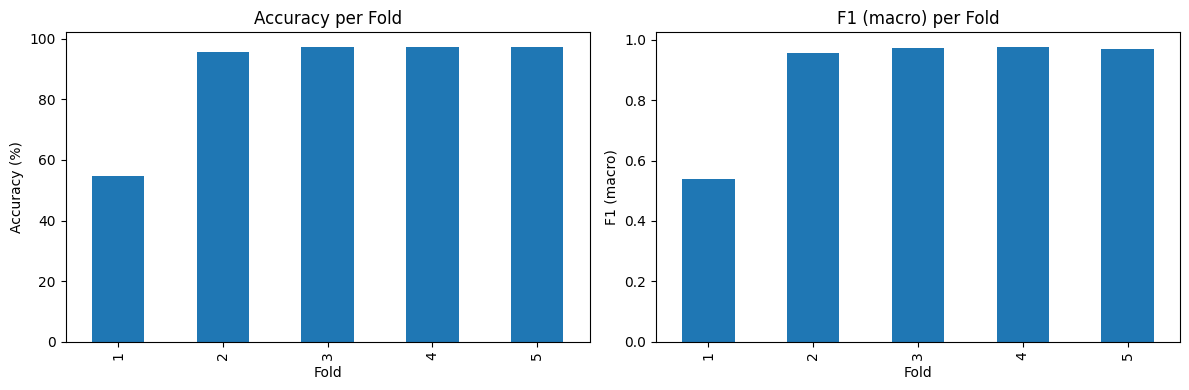

In [11]:
results_df = pd.DataFrame(all_results).sort_values("Fold")
summary = results_df.agg(['mean','std']).transpose()

print("\nPer-fold results:\n", results_df)
print("\nSummary (mean & std):\n", summary)

# save final outputs
results_df.to_csv(f"checkpoints/{args.exp_name}/results_per_fold.csv", index=False)
summary.to_csv(f"checkpoints/{args.exp_name}/results_summary.csv")
print("Saved results to checkpoints folder.")

# after saving CSVs
df = results_df.sort_values("Fold")

# Bar chart: Acc & F1_macro per fold
fig, ax = plt.subplots(1,2, figsize=(12,4))
df.plot(kind='bar', x='Fold', y='Acc', ax=ax[0], legend=False, title='Accuracy per Fold')
ax[0].set_ylabel('Accuracy (%)')
df.plot(kind='bar', x='Fold', y='F1_macro', ax=ax[1], legend=False, title='F1 (macro) per Fold')
ax[1].set_ylabel('F1 (macro)')
plt.tight_layout()
plt.savefig(f"checkpoints/{args.exp_name}/metrics_per_fold.png", dpi=200)
plt.show()
